# Hydrodome Simulation Plotting

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from scipy.ndimage import gaussian_filter
import os
import csv
import copy

## theoretical angular distributions

## plot simulation results

In [2]:
expDiodicity=[]
with open('experimentalDiodicity.csv', newline='\n',encoding='UTF-8-sig') as diodicityCurve:
    reader = csv.reader(diodicityCurve, delimiter=',')
    for i,point in enumerate(reader):
        expDiodicity.append([float(x) for x in point])

In [256]:
class processHydroSim:
    '''
    processes a single simulation of hydrodynamic electron flow through a graphene constriction
    one simulation may constists of several run in parallel'''
    
    def __init__(self, directory, fname, verbose=True, minRunTime=0):
        
        self.directory = directory
        self.fname = fname
        self.filePath = './'+self.directory+'/'+self.fname+'/'
        self.verbose = verbose
        self.minRunTime = minRunTime

        # 2d plotting parameters
        self.symm = False
        self.blur =.3
        
        self.SD = 1.02 # NOTE this is not the SD set by the simulation; 
        #we are free to set this to achieve a given linear response from a SDratio=1 simulation
        self.resolution = .1 # this is not saved by simulation as before 2/2/22

        # source and drain locations; source is below constriction

        
        # get number of parallel simulations in filePath
        files=os.listdir(self.filePath)
        NPZfiles=[file for file in files if "npz" in file]
        self.Nsims=len(NPZfiles)
        
        self.loadInData()
        self.set_analysisType()
        
        top = [1.3,3.4]
        bottom = [-.4,-4.9]
        self.determineDirection()
        if self.direction =='easy':
            self.sourceLoc, self.drainLoc = bottom, top
        else:
            self.sourceLoc, self.drainLoc = top, bottom
                    
        self.removeFicticousEdges() # in the case of islands or a probe tip
        
        
    def set_analysisType(self):
        '''
        determines how we analyze to tabulate particles to calculate voltages and currents'''

        if self.SDratio==1.:
            self.analysisType = 'linear response'
        else:
            self.analysisType = 'data as simulated'
    
    
    def loadInData(self):
        '''
        loads in Nsim npz simulation files located in filePath'''
        
        files=os.listdir(self.filePath)
        NPZfiles=[file for file in files if "npz" in file]
        Nsims=len(NPZfiles)
        excluded_string = ''
        
        for i in range(Nsims):
            with np.load('./'+self.filePath+self.fname+'_%03d.npz'%i) as mat:
            # load in the simulation objects saved as arrays inside an npz file
                if i == 0:

                    # these should be fixed for a given simulation batch
                    self.borderX = mat['borderX']
                    self.borderY = mat['borderY']
                    self.boxL = mat['boxL']
                    self.edgeStyle = mat['edgeStyle']
                    self.histX = mat['histX']
                    self.histY = mat['histY']
                    #self.resolution = mat['fieldResolution'] not in mat before 2/2/22
                    self.stepSize = mat['DeltaX']
                    self.timesteps= mat['timeCount']
                    self.initializationT = mat['initializationCount']
                    self.SDratio = mat['sourceDrainRatio']
                    self.temp = mat['Temp']
                    self.simPartDensity = mat['simPartDensity']
                    self.expPartDensity = mat['expPartDensity']
                    self.pScatter =mat['p_scatter']
                    self.area =mat['Area']
                    self.emin =mat['Emin']
                    self.Npart = mat['Npart']
                    self.contacts = mat['contactLookUp']
                    self.currentMatrix = mat['currentMatrix']
                    self.transportMap = mat['transportMap']
                    self.drainsList = mat['drains']
                    self.sourcesList = mat['sources']
                    self.lengths = mat['lengths']
                    self.contactLengths = mat['lengths'][np.sort(np.append(self.drainsList,self.sourcesList))]
                    
                    # flags simulations if no parallel simulations run sufficently long enough
                    if mat['timeCount']<self.minRunTime:
                        excluded_string += f'exluded {self.fname}, runs: {i}'
                        self.flag= 1 
                        continue
                    else:
                        self.flag = 0
                    
                    self.Erho = mat['Erho'].copy()
                    self.rho = mat['rho'].copy()
                    self.vX = mat['Px'].copy()
                    self.vY = mat['Py'].copy()
                    self.ptcFlux = mat['Nabsorbed']-mat['Ninjected']
                    self.nInjections= mat['Ninjected']
                    self.nAbsorbtions = mat['Nabsorbed']
                    self.totalAbsorbed = sum(self.nAbsorbtions[self.drainsList])

                else: 
                    
                    if mat['timeCount']<self.minRunTime:
                        if excluded_string == '':
                            excluded_string += f'exluded {self.fname}, runs: {i}'
                        else:
                            excluded_string += f',{i}'
                        continue
                    else:
                        self.flag = 0
    
                    self.Erho += mat['Erho']
                    self.rho += mat['rho']
                    self.vX  += mat['Px']
                    self.vY  += mat['Py']
                    self.ptcFlux += mat['Nabsorbed']-mat['Ninjected']
                    self.nInjections += mat['Ninjected']
                    self.nAbsorbtions += mat['Nabsorbed']
                    self.totalAbsorbed += sum(self.nAbsorbtions[self.drainsList])
                    self.currentMatrix += mat['currentMatrix']
                    self.transportMap += mat['transportMap']
                    self.timesteps +=mat['timeCount']

        if excluded_string!='':
            print(excluded_string)
            
                     
     
    def removeFicticousEdges(self):
        '''
        inserts NaN for fictisious edges, so that they are not plotted'''
    
        f=-2
        for edge_idx in np.arange(len(self.edgeStyle)):
            idx_dif = len(self.borderX)-len(self.edgeStyle)  # difference between '' which changes with additions of NaNs
            edge = self.edgeStyle[edge_idx]
            if edge == f:
                self.borderX = np.insert(self.borderX,edge_idx + idx_dif, np.NaN)
                self.borderY = np.insert(self.borderY,edge_idx + idx_dif, np.NaN)
              
            
    def make_colorMesh_plot(self, axis, tw0D_histogram, m1):
        '''
        2d plot assigns colors to gridpoints of histX, histY according 
        to twoD_histogram and vmin and vmax'''
        
        symm =self.symm
        if symm: 
        # if symmetric device, average the histogram over its halves
            tw0D_histogram+=tw0D_histogram[:,::-1]
            tw0D_histogram/=2
        axis.pcolormesh(self.histX,self.histY,tw0D_histogram,cmap = 'gray')#, vmin = .00001*m1,vmax = 2*m1)
        axis.axis('off')
        axis.plot(self.borderX,self.borderY,'r')
        #self.fig1.colorbar(tw0D_histogram,ax=axis)

        # plot source and drain edges with red and green markers
        for iD in self.drainsList:
            axis.plot((self.borderX[iD+1]+self.borderX[iD])/2,(self.borderY[iD+1]+self.borderY[iD])/2,'r.', markersize=15)
        for iS in self.sourcesList:
            axis.plot((self.borderX[iS+1]+self.borderX[iS])/2,(self.borderY[iS+1]+self.borderY[iS])/2,'g.', markersize=15)        
        

    def plot_densityAndVelocity(self):

        blur =0.3 # when averaging 2d histogram, blur sets weights of neighbors
        sigma = 0 # also related to averaging neighbors 

        self.fig1 = plt.figure(figsize = (15,10))
        ax0 = self.fig1.add_subplot(231)
        ax1 = self.fig1.add_subplot(232)
        ax2 = self.fig1.add_subplot(233)
        ax3 = self.fig1.add_subplot(234)
        ax4 = self.fig1.add_subplot(235)

        sliceIdx = 60
        
        #ax0 plots the energy density/particle density
        erho_uponRho_Plot = gaussian_filter(self.Erho.T,blur)/gaussian_filter(self.rho.T,blur)*(self.rho.T>0)
        rhoPlot =gaussian_filter(self.rho.T,blur)*(self.rho.T>0)
        m1 = np.median(np.concatenate([row[np.where(row>0)] for row in rhoPlot]))
        self.make_colorMesh_plot(ax0, rhoPlot, m1)

        #ax1 plots the horizontal velocity distribution
        vXplot = gaussian_filter(self.vX.T,blur)
        m1 = np.max(np.abs(vXplot))
        self.make_colorMesh_plot(ax1, vXplot, m1)
        #ax1.plot(3*np.ones(),self.histY, '--',markersize =14)

        #ax2 plots the vertical velocity distribution
        vYplot = gaussian_filter(self.vY.T,blur)
        m1 = np.max(np.abs(vYplot))
        self.make_colorMesh_plot(ax2, vYplot, m1)

        # velocity magnitude
        vMagPlot = (vXplot**2+vYplot**2)**.5
        m1 = np.max(vMagPlot)
        self.make_colorMesh_plot(ax3, vMagPlot, m1)

        # y velocity across constriction
        #vXslice = vXplot[25:50,sliceIdx]
        #ax4.plot(vXslice)
        ax4.set_xlabel('y position')
        ax4.set_ylabel('x velocity')

        ax0.set_title('voltage? map')
        ax1.set_title('horizontal velocity')
        ax2.set_title('vertical velocity')
        ax3.set_title('velocity magnitude')
        ax4.set_title('y velocity slice (above)')
        ax4.set_yticklabels([])
        ax4.set_xticklabels([])
        
        ax0.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax0.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax1.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax1.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax2.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax2.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        ax3.set_xlim([min(self.borderX)-.2, max(self.borderX)+.2])
        ax3.set_ylim([min(self.borderY)-.2, max(self.borderY)+.2])
        
        self.fig1.suptitle(f'direction: {self.direction}, temp: {self.temp} K, density: {np.round(self.simPartDensity,1)}')
        
    plt.show()
            
    def plot_reinjectionMaps(self):
        '''
        plots N density maps for particles emenating from a specific contact
        plots N absorbtion histograms for emanating from a specific contact'''
        
        contactList = ['top Contact', 'bot Contact']
        blur=0.3
    
        # plot particle density reinjection from a contact
        self.fig2, ax2 = plt.subplots(len(contactList), 2, constrained_layout=True, figsize=[10,20])
        self.fig2.suptitle('Transport Maps (after reinjection from [] contact)', size=15)

        for i,ptcMap in enumerate(self.transportMap):
            transportPlot =gaussian_filter(ptcMap.T,blur)*(ptcMap.T>0)
            m1 = np.median(np.concatenate([row[np.where(row>0)] for row in transportPlot]))
            ax2[i,0].pcolormesh(self.histX,self.histY,transportPlot,cmap = 'gray', vmin = 0.000001*m1,vmax = 1.999999*m1)
            ax2[i,0].plot(self.borderX,self.borderY,'r')
            ax2[i,0].axis('equal')
            ax2[i,0].axis('off')
            ax2[i,0].set_title(contactList[i])

            #generates histograms showing distribution of particles absorbtion
            ax2[i,1].plot(contactList, (self.currentMatrix)[i]/self.contactLengths, '.', markersize=14)
        plt.show()
            
    def calculateReinjectionProbs(self):
        '''
        calculate all ohmic contacts probablities of being a reinjection site when SD=1 
        can be input into future simulations to get proper physical when SD !=1'''
        
        totalReinjections = np.sum(self.nInjections)
        probs = self.nInjections[0:self.nDeviceEdges]/totalReinjections

        nTipEdges = len(self.nInjections)-self.nDeviceEdges
        probs = np.append(probs, np.zeros(nTipEdges))
        self.probs = [round(prob, 8) for prob in probs ]

        
    def define_voltageGrid(self, location):
        '''
        location = [x0,y0] 
        give indicies  of gridpoints centered about location correponds'''
        
        # list of x and y points centered around location=[x0, y0]
        # [-.1 ,.19] offsets from [x0.y0] to give a 5x5 grid with .1um side lengths to average from
        Xpoints = np.arange(location[0]-.3,location[0]+.4,self.resolution)
        Ypoints = np.arange(location[1]-.3,location[1]+.4,self.resolution)
 
        # 2-d arrays with x and y coordinate for each gridpoint
        Xgrid, Ygrid = np.meshgrid(Xpoints, Ypoints)

        # compute "gridpoint indicies" of [y,x] of  by counting number of gridpoints from topmost or leftmost edges of box
        idxs = np.concatenate(np.array([(Ygrid+self.boxL)/self.resolution,(Xgrid+self.boxL)/self.resolution]).T)
        return idxs
        
        
    def measure_ptcCount_woTransportMap(self, location):
        '''
        location = [x0,y0]; 
        measure the particle density at the given location 
        by averaging particle count in a window'''
        
        idxs = self.define_voltageGrid(location)
        
        # calculate particle density in contacts
        ptcCount =[]
        #vGrid = gaussian_filter(rho.T,sigma=0)/gaussian_filter(Erho.T,sigma=0)
        ptcGrid =gaussian_filter(self.rho.T,sigma=0)
        for yxIdx in idxs:
        # find and store particle count at gridpoint at point with yIdx, xIdx
            yIdx,xIdx = int(yxIdx[0]), int(yxIdx[1])
            ptcCount = np.append(ptcCount, ptcGrid[yIdx, xIdx])
            
        self.ptcCount_total = np.sum(self.rho) # all contributions to rho (all particle counts)
        
        ptcCount_avg = np.average(ptcCount[ptcCount>0])
        return ptcCount_avg
    
    
    def measure_ptcCount_wTransportMap(self, location):
        '''
        location = [x0,y0] 
        measure the particle density at the given location by averaging a weighted particle count inside a window.

        for each source/drain, the transport map keeps track of where particles are after reinjection.
        Weight the transport maps by a sqrt(SD) for source reinjections and 1/sqrt(SD) for drain reinjectins
        this keep total # of particles fixed, while summation computes particle count if fractionally (SD) more  emmanated from the source
        all this gurantees we measure the linear response to applied voltage'''
    
        idxs = self.define_voltageGrid(location)
    
        ptcGrid =0
        for i,ptcMap in enumerate(self.transportMap): # ptcMap is ptcCounts after reinjection from ith conctat
            ptcHistogram =gaussian_filter(ptcMap.T,sigma=0) # build histogram from ptcmap
            if self.contacts[i] in self.drainsList: # reinjection from drain
                ptcGrid += 1/self.SD**.5*ptcHistogram
            else: #reinjection from source
                ptcGrid += self.SD**.5*ptcHistogram    
        
        ptcCount =[]
        for yxIdx in idxs:
        # find and store particle count at gridpoint at point with yIdx, xIdx
            yIdx,xIdx = int(yxIdx[0]), int(yxIdx[1])
            ptcCount = np.append(ptcCount, ptcGrid[yIdx, xIdx])
            
        self.ptcCount_total = np.sum(self.rho) # all contributions to rho (all particle counts)
        #THIS IS SOMETHING TO CHECK: MAKE SURE SUM(RHO) SAME AS SUM(PTCGRID)
        
        ptcCount_avg = np.average(ptcCount[ptcCount>0])
        return ptcCount_avg
    
    
    def measure_voltage(self):
        '''
        measures the voltage of an ohmic contact by computing the density needed to set up 
       contact particle absorbtion rate.'''
    
    
        '''# check the analysis type to determine how we calculate particle counts
        if self.analysisType=='linear response':
            ptcCount_source = self.measure_ptcCount_wTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_wTransportMap(self.drainLoc)
        elif self.analysisType== 'data as simulated':
            ptcCount_source = self.measure_ptcCount_woTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_woTransportMap(self.drainLoc)
        
        Ntot = self.ptcCount_total 
        # compute simulation density by comparting ratio of voltageGrid area to device's total area
        # here .1 is a the length of voltageGrid edge
        self.nSource= ptcCount_source*self.area/(.1**2*Ntot)*self.simPartDensity
        self.nDrain= ptcCount_drain*self.area/(.1**2*Ntot)*self.simPartDensity'''
        
        hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
        timestepToSeocnd_ratio=(self.stepSize*1e-6)/vF
 
        w_source = np.sum(self.lengths[self.sourcesList])
        w_drain = np.sum(self.lengths[self.drainsList])
        
        N_inj_source = np.sum(self.nInjections[self.sourcesList])
        N_inj_drain = np.sum(self.nInjections[self.drainsList])
        
        
        Delta_Density_flux=np.pi/vF/self.timesteps/timestepToSeocnd_ratio/vF*(N_inj_source/w_source-N_inj_drain/w_drain)
        self.voltage = hbar*np.sqrt(np.pi)*vF/(2*e)*(Delta_Density_flux)*((self.expPartDensity*1e4)**.5/self.simPartDensity)
        
        # measure voltage across constriction by computing Fermi energy difference / e
        # exp density in 1/cm^2

        
        
    def measure_ptcFlux_wCurrentMatrix(self):
        '''
        measure particles (absorbed - injected) at drains by if more come from source contacts     
        the (i,j) element of current matrix tells us the number of particles absorbed 
        at contact i after reinjection from contact j.
        For each drain, weight the absorbtions by a sqrt(SD) for source reinjections and 1/sqrt(SD) for drain reinjectins
        this keep total particles fixed, while summation computes Nabsorbed if fractionally (SD) more  emmanated from the source
        weight all reinjections from a drain by 1/SD
        sum (absorptions - injections) over all reinjections and then sum over all drains'''
        
        ptcFlux = 0
        totalAbsorbed = 0
        for i,absorbtionData in enumerate(self.currentMatrix.T): #columns of currentMatrix are absorption data; rows are injection data
            if self.contacts[i] in self.drainsList: # sum over only drain (top) contacts

                # weight absorbtion data by sqrt(SD) if ptcs came from source, ie, if column j of self.currentMatrix.T is a source 
                # weight by 1/sqrt(SD) if came from drain
                absorbtions = [x*self.SD**.5 if (self.contacts[j] in self.sourcesList) else x/self.SD**.5 for j,x in enumerate(absorbtionData) ]
                
                injections = self.currentMatrix[i]/self.SD**.5 # weight all injections by drain density percent

                ptcFlux += sum(absorbtions)-sum(injections)

                totalAbsorbed = sum(absorbtionData) # we also keep track of total aborsbed (no weighting) at the drains
                # we noticed this scales with sqrt(simulaiton density) strangely
                
        self.totalAbsorbed = totalAbsorbed 
        self. ptcFlux = ptcFlux
        return self.ptcFlux 
        
    def measure_current(self):
        '''
        count the number of ptcs abosrbed - injected at drains and computes equivlant charge per second'''
        
        # check the analysis type to determine how we calculate particle flux through drain
        if self.analysisType=='linear response':
            ptcFlux = self.measure_ptcFlux_wCurrentMatrix()
        elif self.analysisType== 'data as simulated':
            ptcFlux = sum(self.ptcFlux[self.drainsList])# load in from data and sum over drains

        # compute simulation partilces per timestep since statistics reset at self.initializationT
        if self.timesteps>self.initializationT:
            fluxPerT = np.sum(ptcFlux)/(self.timesteps-self.initializationT)
        else: 
            fluxPerT = np.sum(ptcFlux)/(self.timesteps)
    
        # density ratio = simulation charge: physical electron charge
        e, vF = 1.6e-19, 1e6 # electron charge, Fermi velocity in graphene
        
        #timestepToSeocnd_ratio= (self.stepSize*1e-6)/vF # sim ptcs travel 1e-8m/per timestep at speed vF
        timestepToSeocnd_ratio=(self.stepSize*1e-6)/vF
        
        self.current = (e*fluxPerT*self.expPartDensity*1e-8/self.simPartDensity/timestepToSeocnd_ratio)
    
    def calculate_resistance(self):
        self.resistance = self.voltage/self.current

        # calculates R without voltage,current induvivually
        '''if self.analysisType=='linear response':
            ptcFlux = self.measure_ptcFlux_wCurrentMatrix()
        elif self.analysisType== 'data as simulated':
            ptcFlux = sum(self.ptcFlux[self.drainsList]) # load in from data and sum over drains

        # compute simulation partilces per timestep since statistics reset at self.initializationT
        if self.timesteps>self.initializationT:
            fluxPerT = np.sum(ptcFlux)/(self.timesteps-self.initializationT)
        else: 
            fluxPerT = np.sum(ptcFlux)/(self.timesteps)
            
        # check the analysis type to determine how we calculate particle counts
        if self.analysisType=='linear response':
            ptcCount_source = self.measure_ptcCount_wTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_wTransportMap(self.drainLoc)
        elif self.analysisType== 'data as simulated':
            ptcCount_source = self.measure_ptcCount_woTransportMap(self.sourceLoc)
            ptcCount_drain = self.measure_ptcCount_woTransportMap(self.drainLoc)
        
        Ntot = self.ptcCount_total 
        # compute simulation density by comparting ratio of voltageGrid area to device's total area
        # here .1 is a the length of voltageGrid edge
        self.nSource= ptcCount_source*self.area/(.1**2*Ntot)*self.simPartDensity
        self.nDrain= ptcCount_drain*self.area/(.1**2*Ntot)*self.simPartDensity
        
        hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
 
        self.resistance = .364*1e6*(self.nSource-self.nDrain)/fluxPerT/(self.expPartDensity)**.5'''
        
    def determineDirection(self):
        
        if self.sourcesList[0]>self.drainsList[0]:
            self.direction = 'easy'

        else:
            self.direction = 'hard'
        
    def save(self):
        '''
        save the relevant quantities and parameters into dictionaries'''
        
        self.parameters = {'temp': self.temp, 'SDratio': self.SDratio, 'timesteps':self.timesteps,'flowDirection': self.direction, 'partDensity':self.simPartDensity, 
                           'pScatter': self.pScatter, 'Emin': self.emin, 'Npart':self.Npart, 'Ninjected':self.nInjections, 'Nabsorbed':self.nAbsorbtions}
        self.quantities={'voltage':self.voltage, 'current': self.current, 'resistance': self.resistance, 'totalAbsorbed': self.totalAbsorbed}

    

In [257]:
class storeAndAnalyze_simBatch():
    '''
    this stores the relevant quantities from each simulation in a batch located insdie directory
    also contains functions to perform subseqent analysis on the entire batch
    a batch is where we have set of simulations where each differs from the others in one parameter such as temperature'''
    
    def __init__(self, directory, minRunTime=0):
        
        self.data={}
        self.minRunTime = minRunTime
        
        self.directory = directory
        self.storeData_inDict()
    


    def processHydroSim_protocol(self, fname, i):
        '''
        this defines the procedure for processing a single simulation in the batch
        we use functions from the processHydroSim class'''
        
        sim = processHydroSim(self.directory, fname, minRunTime=self.minRunTime)
        
        if sim.flag == 1:
            pass
        else:
            sim.measure_voltage()
            sim.measure_current()
            sim.calculate_resistance()
            sim.save()
            if i==0:
                _=1
                #sim.plot_densityAndVelocity()
                #plt.show()

        return sim
            
        
    def storeData_inDict(self):
        '''
        store the parameters and quantities of all processed simulations of 
        one bactch into the self.data dictionary'''
        
        fnameBases = os.listdir(self.directory)
        fnameBases = list(set(['_'.join(np.delete(fname.split('_'), -1)) for fname in fnameBases]))
        i=0
        for fname in fnameBases:
            path = './'+self.directory+'/'+fname
            try:
                if (os.path.isdir(path+'_easy')) and (os.path.isdir(path+'_hard')):

                    easySim = self.processHydroSim_protocol(fname+'_easy', i) # defines class for one simulation
                    hardSim = self.processHydroSim_protocol(fname+'_hard', i)
                    if easySim.flag == 1 or hardSim.flag==1:
                        print(f'{fname} flagged')
                        continue
                    # move paramaters/quantitities from the induvidual simulation dictionary into the batch dictionary 
                    for p in easySim.parameters:
                        if i ==0:
                            self.data[p]=[]
                        self.data[p] = np.append(easySim.parameters[p],self.data[p])
                        self.data[p] = np.append(hardSim.parameters[p],self.data[p])
                        
                    for q in easySim.quantities:
                        if i ==0:
                            self.data[q]=[]
                            self.data['diodicity']=[]
                        self.data[q] = np.append(easySim.quantities[q],self.data[q])
                        self.data[q] = np.append(hardSim.quantities[q],self.data[q])
                        
                    diodicity = hardSim.quantities['resistance']/easySim.quantities['resistance']
                    self.data['diodicity']=np.append(diodicity,self.data['diodicity'])
                    self.data['diodicity']=np.append(diodicity,self.data['diodicity'])
                    i+=1
                               
                else:
                    pass

            except UnboundLocalError:
                print(f'Error for {fname}')
                pass
            
        print(f'loaded {i} simulations')
        
    def form_constantZsubset(self, zConstants, xLabel='temp'):
        '''
        forms a boolean array of length self.data
        zConstant has the form [[zLabel1, constant1], ... [zLabelN, constantN]]
        true element if z parameters in the set are equal to the speicifed constant'''
    
        if zConstants==[]: # if no constant parameters specified, include all simulations
                constantZsubset = np.ones(len(self.data[xLabel]), dtype='bool')
        else:
            for i,zConstant in enumerate(zConstants):
                    if i==0:
                        constantZsubset = self.data[zConstant[0]]==zConstant[1]
                    else:
                        constantZsubset *= self.data[zConstant[0]]==zConstant[1]
                
        return constantZsubset
            
    def plot_xVsYi_allZfixed(self,xLabel, yLabel_0, yLabel_1toN=[], zConstants=[]):
        '''
        plot parameter x vs qunatity y0 for constant z variables; also plot y1,..., yN weighted to have y0 average;
        xLabel and yLabel are strings;
        yLabel_N gives N additional labels'''
    
        constantZsubset = self.form_constantZsubset(zConstants)

        x = self.data[xLabel][constantZsubset]
        y0 = self.data[yLabel_0][constantZsubset]
        
        plt.figure(figsize=(6,8))
        plt.plot(x, y0,'.', label=yLabel_0)
        
        # weight each yi appropriately and plot
        for i,yLabel_i in enumerate(yLabel_1toN):
            yi = self.data[yLabel_i][constantZsubset]
            yi = yi*np.average(y0)/np.average(yi)
            plt.plot(x,yi,'.', label = yLabel_i)

        plt.xlabel(xLabel)
        plt.legend()
        #plt.title("0.5 um PC (current = nAbs-nInj)")
        
        
    def plot_xVsProductYi_allZfixed(self, xLabel, yLabel, powerLaw=[1,1], zConstants=[]):
        '''
        plot the product of variables y0^power0 * ... * yN^powerN vs x for constant z variables;
        yLabel is a list of labels'''
    
        constantZsubset = self.form_constantZsubset(zConstants)
 
        x = self.data[xLabel][constantZsubset]
    
        # compute product of yi, over 0 to N
        for i,yLabel_i in enumerate(yLabel):
            if i ==0:
                y = self.data[yLabel[i]][constantZsubset]**powerLaw[0]
            else:
                y *= self.data[yLabel[i]][constantZsubset]**powerLaw[0]

        plt.figure(figsize=(6,8))
        plt.plot(x, y, '.', label=f'at {zConstant[0]}={zCosntant[1]}')

        plt.title(f'producut of {yLabel} raised respectively to {powerLaw}')
        plt.xlabel(xLabel)
        plt.legend()
        
        
    def plot_xVsProductYi_forEachZfixed(self,xLabel, yLabel, powerLaw=[1,1], zConstants=[]):
        '''
        plot the product of two variables w^power0 * y^power1 vs x 
        make one plot for constant z variable specified'''
    
        fig,ax = plt.subplots(figsize=(6,8))
        
        for zConstant in zConstants:
            constantZsubset = self.form_constantZsubset([zConstant])
            x = self.data[xLabel][constantZsubset]

            # compute product of yi, over 0 to N
            for i,yLabel_i in enumerate(yLabel):
                if i ==0:
                    y = self.data[yLabel_i][constantZsubset]**powerLaw[i]
                else:
                    y *= self.data[yLabel_i][constantZsubset]**powerLaw[i]

            ax.plot(x, y, '.', label=f'at {zConstant[0]}={zConstant[1]}')

        ax.set_title(label=f'producut of {yLabel} raised respectively to {powerLaw}')
        ax.set_xlabel(xLabel)
        ax.legend()




In [8]:
_2_14_22=storeAndAnalyze_simBatch('2-14-22_Tsweep_n35_compute', minRunTime=7000000)

exluded teslaValve_T93_n35_compute_easy, runs: 0
teslaValve_T93_n35_compute flagged
exluded teslaValve_T23_n35_compute_hard, runs: 0
teslaValve_T23_n35_compute flagged
exluded teslaValve_T44_n35_compute_easy, runs: 0
teslaValve_T44_n35_compute flagged
exluded teslaValve_T100_n35_compute_easy, runs: 0
teslaValve_T100_n35_compute flagged
exluded teslaValve_T107_n35_compute_hard, runs: 0
teslaValve_T107_n35_compute flagged
exluded teslaValve_T51_n35_compute_hard, runs: 0
teslaValve_T51_n35_compute flagged
exluded teslaValve_T121_n35_compute_hard, runs: 0
teslaValve_T121_n35_compute flagged
exluded teslaValve_T2_n35_compute_easy, runs: 0
teslaValve_T2_n35_compute flagged
exluded teslaValve_T114_n35_compute_hard, runs: 0
teslaValve_T114_n35_compute flagged
exluded teslaValve_T58_n35_compute_hard, runs: 0
teslaValve_T58_n35_compute flagged
exluded teslaValve_T79_n35_compute_easy, runs: 0
teslaValve_T79_n35_compute flagged
loaded 8 simulations


No handles with labels found to put in legend.


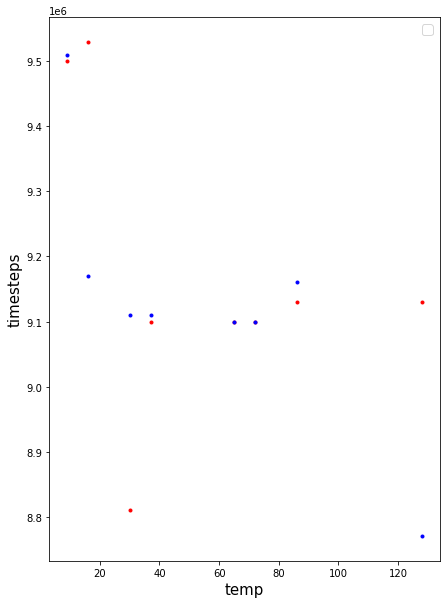

In [9]:
data=_2_14_22.data

parameter = 'temp'
quantity='timesteps'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.')
plt.plot(hardX, hardY, 'b.')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        plt.xlim(0,100)
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})


exluded teslaValve_T60_n35_compute_easy, runs: 0
teslaValve_T60_n35_compute flagged
loaded 13 simulations


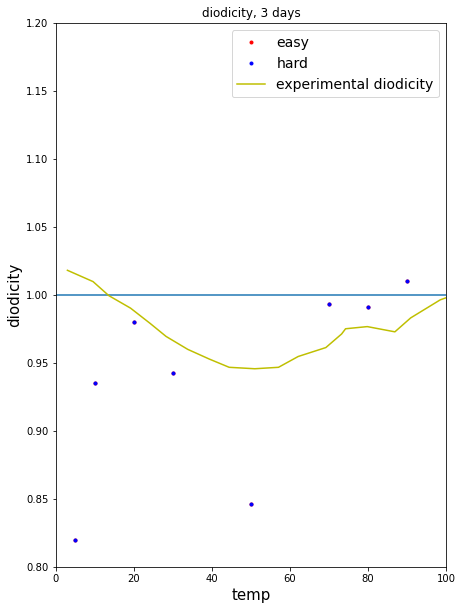

In [10]:
_4_26_22=storeAndAnalyze_simBatch('4-26-22_compute_partition_SD1.14_diffusive_ran3days', minRunTime=1.5e6)

data=_4_26_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        plt.xlim(0,100)
        plt.ylim(.8,1.2)
plt.title('diodicity, 3 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})



exluded teslaValve_T60_n35_compute_easy, runs: 0
teslaValve_T60_n35_compute flagged
loaded 13 simulations


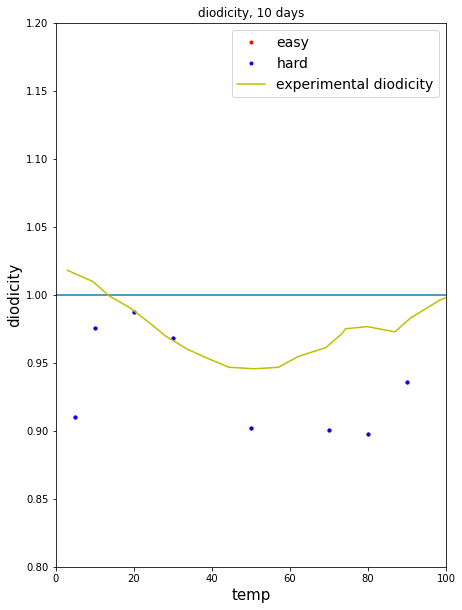

In [11]:
_5_5_22=storeAndAnalyze_simBatch('5-5-22_compute_partition_SD1.14_diffusive_ran9days', minRunTime=1.5e6)

data=_5_5_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        plt.xlim(0,100)
        plt.ylim(.8,1.2)
plt.title('diodicity, 10 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})



In [13]:
_5_11_22=storeAndAnalyze_simBatch('5-11-22_Tsweep_n35_ran17days', minRunTime=1.5e6)

exluded teslaValve_T60_n35_compute_easy, runs: 0
teslaValve_T60_n35_compute flagged
loaded 12 simulations


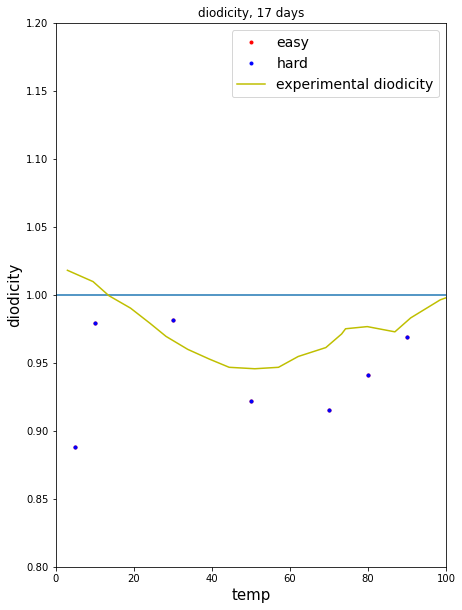

In [15]:
data=_5_11_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14


easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        plt.xlim(0,100)
        plt.ylim(.8,1.2)
plt.title('diodicity, 17 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})


loaded 19 simulations


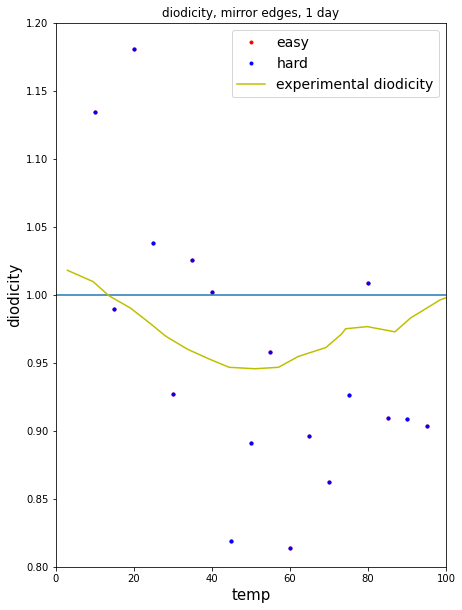

In [16]:
_5_12_22=storeAndAnalyze_simBatch('5-12-22_compute_Tsweep_mirrorEdges_n35_SD1.14', minRunTime=0)

data=_5_12_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14


easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        plt.xlim(0,100)
        plt.ylim(.8,1.2)
plt.title('diodicity, mirror edges, 1 day')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})




loaded 19 simulations


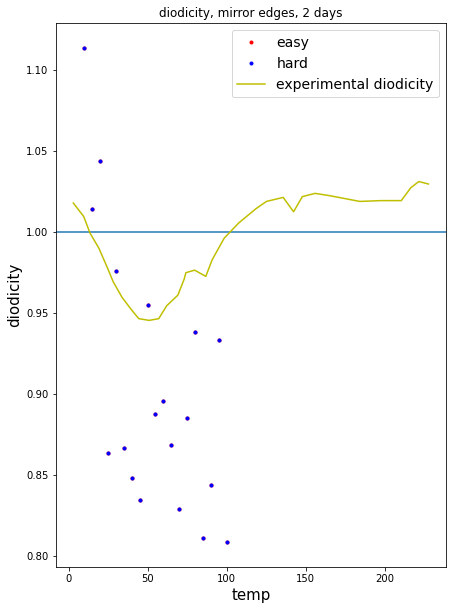

In [ ]:
_5_13_22=storeAndAnalyze_simBatch('5-13-22_compute_Tsweep_mirrorEdges_n35_SD1.14', minRunTime=0)

data=_5_13_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        #plt.xlim(0,100)
        #plt.ylim(.8,1.2)
plt.title('diodicity, mirror edges, 2 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})





loaded 19 simulations


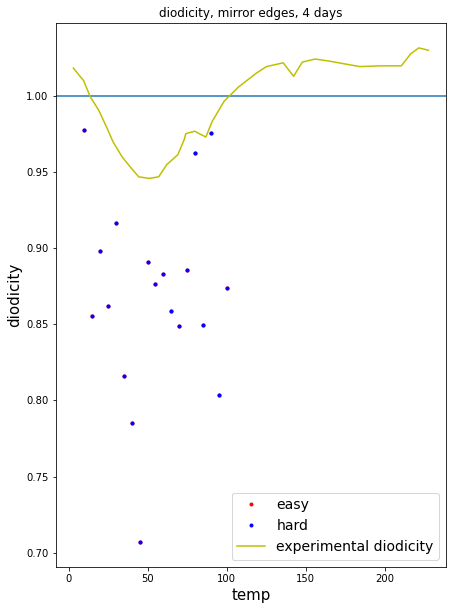

In [233]:
_5_15_22=storeAndAnalyze_simBatch('5-15-22_compute_Tsweep_mirrorEdges_n35_SD1.14', minRunTime=0)

data=_5_15_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        #plt.xlim(0,100)
        #plt.ylim(.8,1.2)
plt.title('diodicity, mirror edges, 4 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})






loaded 19 simulations


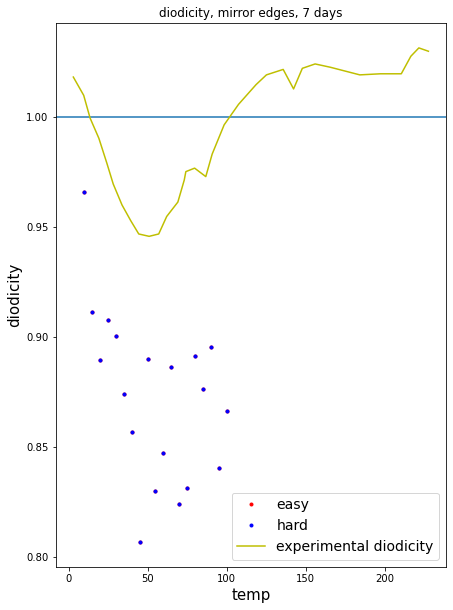

In [237]:
_5_18_22=storeAndAnalyze_simBatch('5-18-22_compute_Tsweep_mirrorEdges_n35_SD1.14', minRunTime=0)

data=_5_18_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        #plt.xlim(0,100)
        #plt.ylim(.8,1.2)
plt.title('diodicity, mirror edges, 7 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":14})







loaded 19 simulations


Text(0, 0.5, 'diodicity')

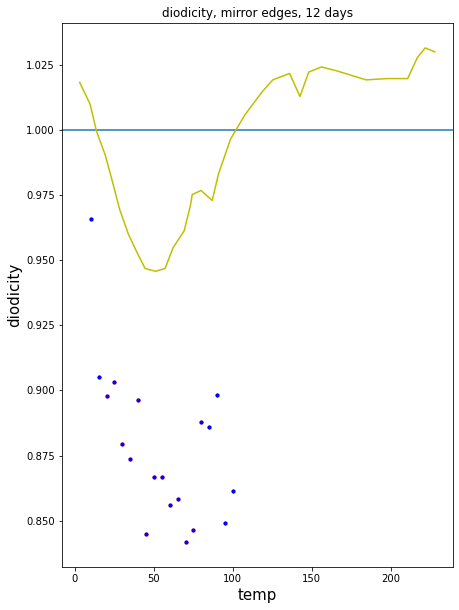

In [420]:
_5_23_22=storeAndAnalyze_simBatch('5-23-22_compute_Tsweep_mirrorEdges_n35_SD1.14', minRunTime=0)

data=_5_23_22.data

parameter = 'temp'
quantity='diodicity'
constantParam = 'SDratio'
constantValue = 1.14

easyX, easyY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='easy')]
hardX, hardY = data[parameter][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')],data[quantity][(data[constantParam]==constantValue)*(data['flowDirection']=='hard')]
plt.figure(figsize=(7,10))
plt.plot(easyX, easyY,'r.', label='easy')
plt.plot(hardX, hardY, 'b.',label='hard')
if 'diodicity' in quantity.split():
    plt.axhline(1)
    if parameter=='temp':
        plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
        #plt.xlim(0,100)
        #plt.ylim(.8,1.2)
plt.title('diodicity, mirror edges, 12 days')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
#plt.legend(prop={"size":14})

/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/3967197617.py:190: RuntimeWarning: invalid value encountered in true_divide
  erho_uponRho_Plot = gaussian_filter(self.Erho.T,blur)/gaussian_filter(self.rho.T,blur)*(self.rho.T>0)
/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/3967197617.py:190: RuntimeWarning: invalid value encountered in true_divide
  erho_uponRho_Plot = gaussian_filter(self.Erho.T,blur)/gaussian_filter(self.rho.T,blur)*(self.rho.T>0)


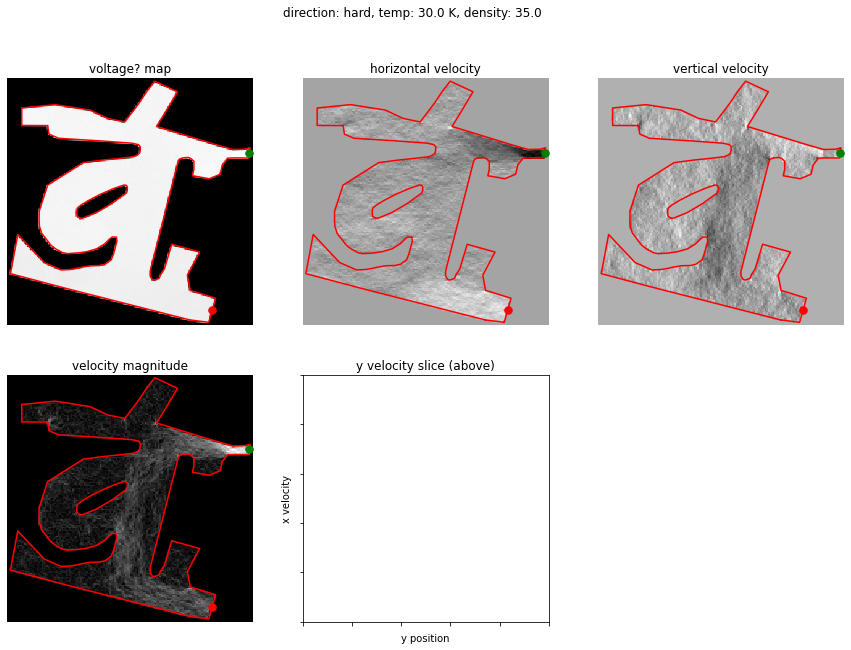

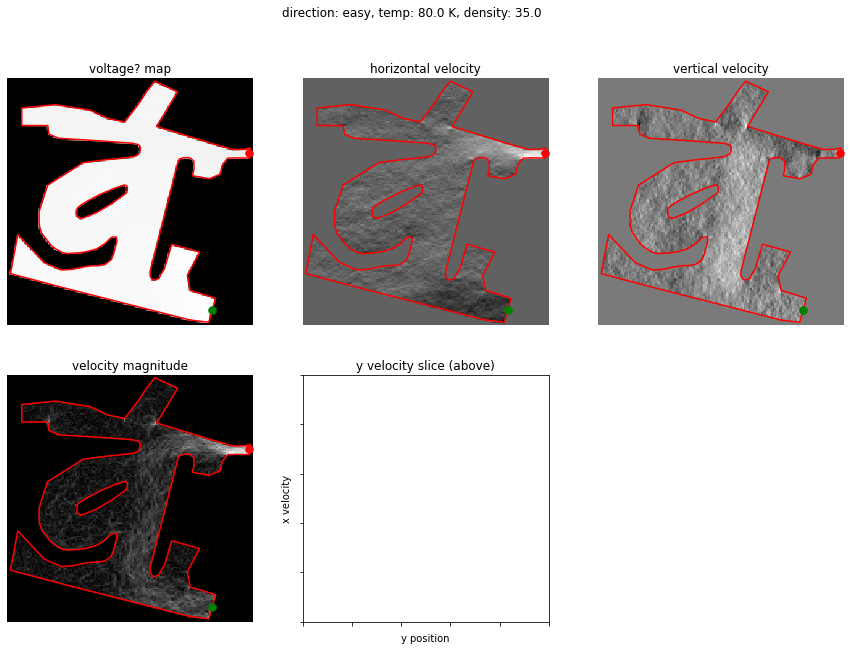

In [403]:
directory = '5-18-22_compute_Tsweep_mirrorEdges_n35_SD1.14'

mirror_10k_hard = processHydroSim(directory, 'teslaValve_T10_n35_compute_mirror_hard')
mirror_10k_easy = processHydroSim(directory, 'teslaValve_T10_n35_compute_mirror_easy')
mirror_20k_hard = processHydroSim(directory, 'teslaValve_T20_n35_compute_mirror_hard')
mirror_20k_easy = processHydroSim(directory, 'teslaValve_T20_n35_compute_mirror_easy')
mirror_30k_hard = processHydroSim(directory, 'teslaValve_T30_n35_compute_mirror_hard')
mirror_30k_easy = processHydroSim(directory, 'teslaValve_T30_n35_compute_mirror_easy')
mirror_40k_hard = processHydroSim(directory, 'teslaValve_T40_n35_compute_mirror_hard')
mirror_40k_easy = processHydroSim(directory, 'teslaValve_T40_n35_compute_mirror_easy')
mirror_45k_hard = processHydroSim(directory, 'teslaValve_T45_n35_compute_mirror_hard')
mirror_45k_easy = processHydroSim(directory, 'teslaValve_T45_n35_compute_mirror_easy')
mirror_80k_hard = processHydroSim(directory, 'teslaValve_T80_n35_compute_mirror_hard')
mirror_80k_easy = processHydroSim(directory, 'teslaValve_T80_n35_compute_mirror_easy')
mirror_100k_hard = processHydroSim(directory, 'teslaValve_T100_n35_compute_mirror_hard')
mirror_100k_easy = processHydroSim(directory, 'teslaValve_T100_n35_compute_mirror_easy')

sim = mirror_30k_hard
sim.plot_densityAndVelocity()
sim = mirror_80k_easy
sim.plot_densityAndVelocity()


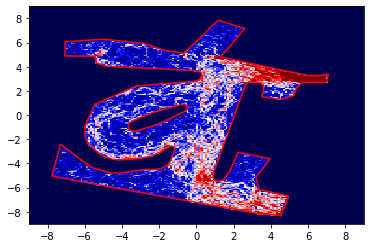

In [399]:
sim1 = mirror_45k_easy

blur=0.3

rhoPlot =gaussian_filter(sim1.rho.T,blur)*(sim1.rho.T>0)
m1 = np.median(np.concatenate([row[np.where(row>0)] for row in rhoPlot]))

vXplot = gaussian_filter(sim1.vX.T,blur)
m1 = np.max(np.abs(vXplot))

vYplot = gaussian_filter(sim1.vY.T,blur)
m1 = np.max(np.abs(vYplot))

vMagplot = (vXplot**2+vYplot**2)**.5
m1 = np.max(vMagPlot)

pc=vMagplot
m1 = np.median(vMagplot[vMagplot>0])

plt.pcolormesh(sim1.histX,sim1.histY,pc, cmap = 'seismic', vmin = 0,vmax = 4*m1)
plt.plot(sim1.borderX,sim1.borderY,'r')

## Subtracting Off Early Saves 

In [327]:
def measure_current(nAbs,nInj,timesteps, hard_or_easy,expPartDensity=2e12,simPartDensity=35):

    e, vF = 1.6e-19, 1e6 # electron charge, Fermi velocity in graphene
    stepSize=.01
    timestepToSeocnd_ratio=(stepSize*1e-6)/vF

    if hard_or_easy=='easy':
        fluxPerT = (nAbs[63]-nInj[63])/timesteps
    else:
        fluxPerT = (nAbs[91]-nInj[91])/timesteps

    current = e*fluxPerT*expPartDensity*1e-8/simPartDensity/timestepToSeocnd_ratio

    return current

In [328]:
def measure_voltage(nInj,timesteps,hard_or_easy,expPartDensity=2e12,simPartDensity=35):
    
    hbar, e, vF = 1.06e-34,1.6e-19, 1e6 # hbar, electron charge, fermi velocity in graphene
    stepSize=.01
    timestepToSeocnd_ratio=(stepSize*1e-6)/vF

    if hard_or_easy=='easy':
        w_source = 1.6667840292011453
        w_drain = 0.6968364226990433
        N_inj_source = nInj[91]
        N_inj_drain = nInj[63]
    else:
        w_source = 0.6968364226990433
        w_drain = 1.6667840292011453
        N_inj_source = nInj[63]
        N_inj_drain = nInj[91]


    Delta_Density_flux=np.pi/vF/timesteps/timestepToSeocnd_ratio/vF*(N_inj_source/w_source-N_inj_drain/w_drain)
    voltage = hbar*np.sqrt(np.pi)*vF/(2*e)*(Delta_Density_flux)*((expPartDensity*1e4)**.5/simPartDensity)
    
    return voltage

In [203]:
def subtract_off_stats(sim1_data,sim2_data):
    
    '''
    subtracts off the injection/absorbtions stats of a previously saved simulation batch (sim_1)
    from the most recent save (sim_2); computes quantitiies of interest''' 

    sim1_save  = [copy.copy(sim1_data['Nabsorbed']), copy.copy(sim1_data['Ninjected'])]
    sim2_save  = [copy.copy(sim2_data['Nabsorbed']), copy.copy(sim2_data['Ninjected'])]
    
    Temps = np.array([])
    flowDs = np.array([])
    times = np.array([])
    currents = np.array([])
    voltages = np.array([])
    resistances = np.array([])
    
    # convert a concatenated injection/absorbtion data into n separate arrays
    # overwrites these in the original simulation data file
    nEdges = 112
    nSplit = len(sim1_data['Nabsorbed'])/nEdges
    _sim1_nAbs_all = np.split(sim1_data['Nabsorbed'], nSplit)
    _sim1_nInj_all = np.split(sim1_data['Ninjected'], nSplit)
    sim1_data['Nabsorbed'] = _sim1_nAbs_all
    sim1_data['Ninjected'] = _sim1_nInj_all
    
    
    nSplit = len(sim2_data['Nabsorbed'])/nEdges
    _sim2_nAbs_all = np.split(sim2_data['Nabsorbed'], nSplit)
    _sim2_nInj_all = np.split(sim2_data['Ninjected'], nSplit)
    sim2_data['Nabsorbed'] = _sim2_nAbs_all
    sim2_data['Ninjected'] = _sim2_nInj_all
    
    
    for i,T in enumerate(sim1_data['temp']):
        try:
            
            # get first simulation data
            sim1_nAbs = sim1_data['Nabsorbed'][i]
            sim1_nInj = sim1_data['Ninjected'][i]
            flowD = sim1_data['flowDirection'][i]
            sim1_time = sim1_data['timesteps'][i]
                        
            # find corresponding second simulation
            oneSim_subset = np.where((sim2_data['temp']==T)*(sim2_data['flowDirection']==flowD))[0]
            if oneSim_subset.size==1:
                
                # get second simulation data
                sim2_nAbs = sim2_data['Nabsorbed'][oneSim_subset[0]]
                sim2_nInj = sim2_data['Ninjected'][oneSim_subset[0]]
                sim2_time = sim2_data['timesteps'][oneSim_subset[0]]
                    
                # take difference
                nAbs_out = sim2_nAbs-sim1_nAbs
                nInj_out = sim2_nInj-sim1_nInj
                time_dif = sim2_time-sim1_time
                
                # get relevant quantites
                V = measure_voltage(nInj_out,time_dif,flowD)
                I = measure_current(nAbs_out,nInj_out,time_dif, flowD)
                R = V/I
            
                flowDs = np.append(flowDs, flowD)
                Temps = np.append(Temps, T)
                times = np.append(times, time_dif)
                voltages = np.append(voltages,V)
                currents = np.append(currents, I)
                resistances = np.append(resistances, R) 
            
        except UnboundLocalError:
            pass
    
    data={'temp': Temps, 'flowDirection':flowDs, "current": currents, 'voltage':voltages,
          'resistance':resistances, 'timesteps':times}
    
    diodicities = np.array([])
    temps_forDio = np.array([])
    
    
    # compute diodicities and store separately
    easySims = data['flowDirection']=='easy'
    for i,R_easy in enumerate(data['resistance'][easySims]):
        
        _T = data['temp'][easySims][i]
        hardSim = (data['temp']==_T)*(data['flowDirection']=='hard')
        R_hard = data['resistance'][hardSim]
        
        diodicity = R_hard/R_easy
        
        temps_forDio = np.append(temps_forDio, _T)
        diodicities = np.append(diodicities, diodicity)
    
    [sim1_data['Nabsorbed'], sim1_data['Ninjected']] = copy.copy(sim1_save)
    [sim2_data['Nabsorbed'], sim2_data['Ninjected']] = copy.copy(sim2_save)
    
    DiodicityData = {'temp': temps_forDio, 'diodicity':diodicities}
    
    return data, DiodicityData
                        

### Diffusive Edges, ran 17 days

/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/1968780039.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  Delta_Density_flux=np.pi/vF/timesteps/timestepToSeocnd_ratio/vF*(N_inj_source/w_source-N_inj_drain/w_drain)
/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/1968780039.py:19: RuntimeWarning: invalid value encountered in double_scalars
  Delta_Density_flux=np.pi/vF/timesteps/timestepToSeocnd_ratio/vF*(N_inj_source/w_source-N_inj_drain/w_drain)
/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/3314707986.py:10: RuntimeWarning: invalid value encountered in double_scalars
  fluxPerT = (nAbs[91]-nInj[91])/timesteps
/var/folders/2q/zwhp08x13v922d11l_dgr4t80000gn/T/ipykernel_39398/3314707986.py:8: RuntimeWarning: invalid value encountered in double_scalars
  fluxPerT = (nAbs[63]-nInj[63])/timesteps


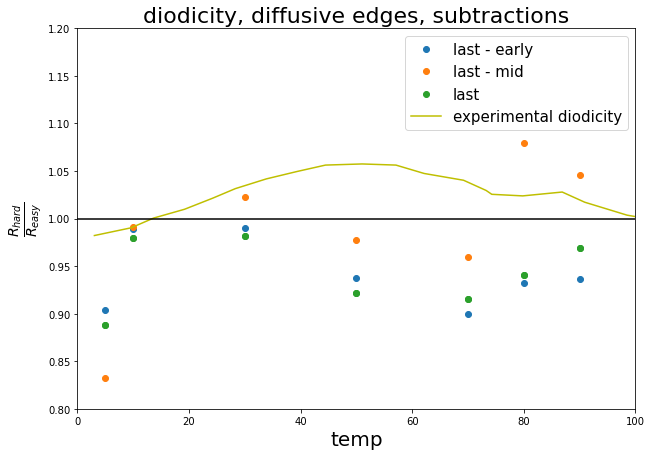

In [418]:
_, dioData_lastMinusEarly = subtract_off_stats(_4_26_22.data,_5_11_22.data)
_, dioData_midMinusEarly = subtract_off_stats(_4_26_22.data,_5_5_22.data)
_, dioData_lastMinusMid = subtract_off_stats(_5_5_22.data,_5_11_22.data)

plt.figure(figsize=(10,7))
dioData = dioData_lastMinusEarly
plt.plot(dioData['temp'], dioData['diodicity'], '.',markersize=12, label='last - early')

dioData = dioData_midMinusEarly
#plt.plot(dioData['temp'], dioData['diodicity'], '.',markersize=12,label='mid - early')

dioData = dioData_lastMinusMid
plt.plot(dioData['temp'], dioData['diodicity'], '.', markersize=12, label='last - mid')

dioData = _5_11_22.data
plt.plot(dioData['temp'], dioData['diodicity'], '.', markersize=12,label='last')

plt.plot(np.array(expDiodicity).T[0],np.array(expDiodicity).T[1],'y', label="experimental diodicity")
plt.axhline(1, color='k')
plt.xlim(0,100)
plt.ylim(.8,1.2)
plt.title('diodicity, diffusive edges, subtractions', size=22)
plt.xlabel(parameter, size=20)
plt.ylabel(r'$\frac{R_{hard}}{R_{easy}}$', size = 20)
plt.legend(prop={"size":15})

### Mirror Edges, ran 30 days

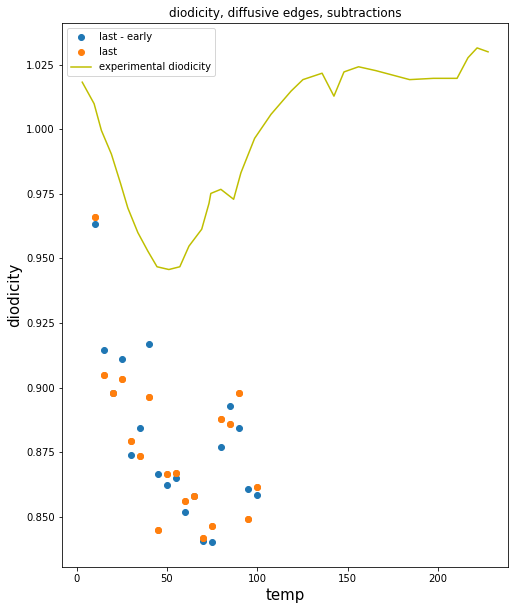

In [429]:
_, dioData_lastMinusEarly = subtract_off_stats(_5_15_22.data,_5_23_22.data)
_, dioData_midMinusEarly = subtract_off_stats(_5_12_22.data,_5_15_22.data)
_, dioData_lastMinusMid = subtract_off_stats(_5_18_22.data,_5_23_22.data)

plt.figure(figsize=(8,10))
dioData = dioData_lastMinusEarly
plt.plot(dioData['temp'], dioData['diodicity'], '.',markersize=12, label='last - early')

dioData = dioData_midMinusEarly
#plt.plot(dioData['temp'], dioData['diodicity'], '.',markersize=12,label='mid - early')

dioData = dioData_lastMinusMid
#plt.plot(dioData['temp'], dioData['diodicity'], '.', markersize=12, label='last - mid')

dioData = _5_23_22.data
plt.plot(dioData['temp'], dioData['diodicity'], '.', markersize=12,label='last')

plt.plot(np.array(expDiodicity).T[0],1/np.array(expDiodicity).T[1],'y', label="experimental diodicity")
#plt.xlim(0,100)
#plt.ylim(.8,1.2)
plt.title('diodicity, diffusive edges, subtractions')
plt.xlabel(parameter, size=15)
plt.ylabel(quantity, size = 15)
plt.legend(prop={"size":10})

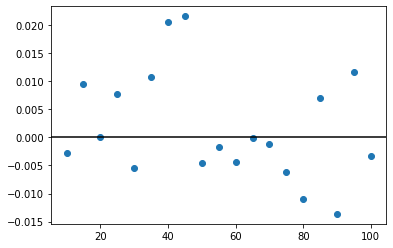

In [438]:
latestData = dioData['diodicity'][dioData['flowDirection']=='easy']

plt.plot(dioData_lastMinusEarly['temp'], dioData_lastMinusEarly['diodicity']-latestData, '.', markersize=12,label='last')
plt.axhline(0, color='k')